<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_2_3/a2_skeleton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:

# Student 1:

# Student 2:

# Student 3:

# Downloading Data and Preliminaries

In [39]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import torch
from zipfile import ZipFile
import requests
import io

In [7]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [8]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [35]:
a = positions_train[:,0,:,:] #initial positions
a.reshape(10000,10)
np.concatenate((a.reshape(10000,10),velocities_train.reshape(10000,10),charges_train.reshape(10000,5)),axis=1).shape

(10000, 25)

In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

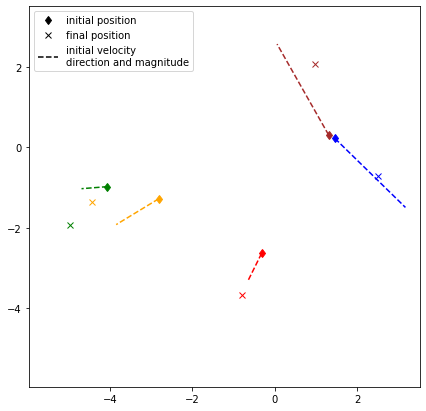

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [59]:
#todo
from torch.utils.data import Dataset, DataLoader,TensorDataset
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [40]:

class DatasetClass(Dataset):
    def __init__(self, positions, velocities,charges):
        
        (samples,seq_length,dim,length) = positions.shape
        # Get the initial positions
        init_pos = positions[:,0,:,:]
        init_pos = init_pos.reshape(samples,dim*length) # Flatten x,y to a single list [x1,x2...,x5,y1,y2...,y5]
        # Get the initial velocities
        init_vel = velocities.reshape(samples,dim*length) # Flatten x,y to a single list [x1,x2...,x5,y1,y2...,y5]
        # Get the charges
        c = charges.reshape(samples,length) # Flatten (samples,1,length) -> (samples,length)
        # Create the feature array using initial state
        features = np.concatenate((init_pos,init_vel,c),axis=1) # Concatenate initial information to a feature array
        
        #Create targets using positions in timesteps after the initial one and flattening the dimensions to a single list
        targets = positions[:,1:,:,:].reshape(samples,seq_length - 1, dim*length)
        
        self.data = torch.FloatTensor(features)
        self.targets = torch.FloatTensor(targets)
        # Sanity checks
        assert features.shape == (samples,dim*length*2 + length)
        assert targets.shape == (samples,seq_length - 1, dim*length)
        
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        

        return x, y
    
    def __len__(self):
        return len(self.data)

In [43]:
train_dataset = DatasetClass(positions_train,velocities_train,charges_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=10)
valid_dataset = DatasetClass(positions_valid, velocities_valid, charges_valid)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=10)
test_dataset = DatasetClass(positions_test, velocities_test, charges_test)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

# Model Implementation

In [ ]:
#todo

In [80]:
from torch import nn
class LSTMRegressor(nn.Module):

    def __init__(self, input_dim, n_layers, hidden_dim,output_dim,device):
        super(LSTMRegressor, self).__init__()
        
        self.input_dim = input_dim
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
    
        self.cell1 = nn.LSTMCell(input_dim, hidden_dim, n_layers)
        self.cell2 = nn.LSTMCell(input_dim, hidden_dim, n_layers)
        self.cell3 = nn.LSTMCell(input_dim, hidden_dim, n_layers)
        
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        #self.drop = nn.Dropout(p=0.5)
        
        self.criterion = nn.MSELoss()
        
        self.optimizer = torch.optim.Adam(self.parameters())
        

    def forward(self, batch_input):
        
        # input shapes:
        # batch_input: [batch_size, seq_length, input_shape]
        
        # Generate initial hidden and cell states
        hidden0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        c0 = torch.randn(batch_input.shape[0], self.hidden_dim).to(self.device)
        
        # Feed packed input sequence to lstm 
        hidden1, c1 = self.cell1(batch_input,(hidden0,c0))
        hidden2, c2 = self.cell2(batch_input,(hidden1,c1)) # Feed same input to all for now
        hidden3, c3 = self.cell3(batch_input,(hidden2,c2)) # Feed same input to all for now
        
        
        # retrieve final hidden output of last timestep for each sequence
        # shape [batch_size, hidden_dim]
        #last_timestep = out[:,-1]
        
        # apply dropout
        #self.drop(last_timestep)
        
        # feed lstm output to MLP, apply ReLU nonlinearity
        # shape [batch_size, hidden_dim]
        h1 = nn.ReLU()(self.fc1(hidden1))
        output1 = self.fc2(h1)
        h2 = nn.ReLU()(self.fc1(hidden2))
        output2 = self.fc2(h2)
        h3 = nn.ReLU()(self.fc1(hidden3))
        output3 = self.fc2(h3)
        #h = nn.ReLU()(h)
        
        y_preds = torch.stack((output1,output2,output3),axis=1) # (Batch_size,3,dim * length)
        return y_preds

torch.Size([10, 3, 10])

# Model Training

In [46]:
def save_model_checkpoint(path, model, optimizer, val_loss, val_acc, train_acc, train_loss ):
    if path == None:
        return print("Kindly define a path")
    path = path
    
    save_dict = {"model_dict" : model.state_dict(), 
                 "optimizer_dict": optimizer.state_dict(),
                 "val_loss_dict": val_loss,
                 "val_acc_dict": val_acc,
                 "train_acc_dict": train_acc,
                 "train_loss_dict": train_loss}
    torch.save(save_dict, path)
    return print("Model Saved to ==> {}".format(path))

In [70]:
# training and validation after every epoch
def train(model, train_loader, val_loader, criterion, num_epochs, save_name):
    best_val_loss = float("Inf") 
    train_losses = []
    val_losses = []
    train_acc = []
    val_acc = []
    cur_step = 0
    train_pred = []
    val_pred = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        running_train_acc = 0.0
  
        model.train()
        print("Starting epoch " + str(epoch+1))
        for train_data, targets in train_loader:
            
           
            # Forward
            input_tensor = train_data.to(device)
            outputs = model.forward(input_tensor)
            loss = criterion(outputs,targets.to(device))
            
                
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()   
            running_loss += loss
          

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print("Train Pass Completed")

        ########################################|Validation Set|#############################################
        val_running_loss = 0.0
        with torch.no_grad():
            model.eval()
            for val_data, val_targets in val_loader:
                input_tensor = val_data.to(device)
                outputs = model.forward(input_tensor)
                loss = criterion(outputs,val_targets.to(device))
                val_running_loss += loss

        avg_val_loss = val_running_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        
        print('Epoch [{}/{}],Train Loss: {:.4f}, Valid Loss: {:.8f}' 
            .format(epoch+1, num_epochs, avg_train_loss, avg_val_loss))
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss 
            save_model_checkpoint(save_name, model, optimizer, best_val_loss, 0, 0, avg_train_loss )
    
    print("Finished Training") 
    return train_losses, val_losses
     

In [71]:
LSTM_reg = LSTMRegressor(25,1,128,10).cuda()

optimizer = torch.optim.SGD(LSTM_reg.parameters(), lr=0.01, momentum=0.9)
num_epochs = 50
save_name = f'LSTM_reg.pt'
criterion = nn.MSELoss()

obtained_train_loss, obtained_val_loss = train(LSTM_reg, 
                                                      train_loader, valid_loader, criterion, num_epochs, save_name)

Starting epoch 1
Train Pass Completed
Epoch [1/50],Train Loss: 2.3620, Valid Loss: 0.66562814
Model Saved to ==> LSTM_reg.pt
Starting epoch 2
Train Pass Completed
Epoch [2/50],Train Loss: 0.5390, Valid Loss: 0.42256618
Model Saved to ==> LSTM_reg.pt
Starting epoch 3
Train Pass Completed
Epoch [3/50],Train Loss: 0.3869, Valid Loss: 0.33757225
Model Saved to ==> LSTM_reg.pt
Starting epoch 4
Train Pass Completed
Epoch [4/50],Train Loss: 0.3189, Valid Loss: 0.29912168
Model Saved to ==> LSTM_reg.pt
Starting epoch 5
Train Pass Completed
Epoch [5/50],Train Loss: 0.2792, Valid Loss: 0.27357644
Model Saved to ==> LSTM_reg.pt
Starting epoch 6
Train Pass Completed
Epoch [6/50],Train Loss: 0.2523, Valid Loss: 0.25308612
Model Saved to ==> LSTM_reg.pt
Starting epoch 7
Train Pass Completed
Epoch [7/50],Train Loss: 0.2323, Valid Loss: 0.23746575
Model Saved to ==> LSTM_reg.pt
Starting epoch 8
Train Pass Completed
Epoch [8/50],Train Loss: 0.2184, Valid Loss: 0.22772773
Model Saved to ==> LSTM_reg.pt


# Evaluation

In [ ]:
#todo

In [82]:
#Evaluating on the validation set

def evaluate(model, test_loader,device='cpu'):
    val_running_loss = 0.0
    preds = []
    actual = []
    with torch.no_grad():
        model.eval()
        for val_data, val_targets in test_loader:
            input_tensor = val_data.to(device)
            outputs = model.forward(input_tensor)
            preds.append(outputs)
            actual.append(val_targets)
            loss = criterion(outputs,val_targets.to(device))
            val_running_loss += loss

        avg_val_loss = val_running_loss / len(test_loader)
        print("Average Test Loss: {:4f}".format(avg_val_loss))
        return preds,actual

In [84]:
#Model Evaluation
model = LSTMRegressor(25,1,128,10,'cpu')
checkpoint = torch.load('LSTM_reg.pt', map_location = 'cpu')
model.load_state_dict(checkpoint['model_dict'])

preds,actual = evaluate(model, test_loader)

Average Test Loss: 0.151195


In [101]:
def plot_positions(preds_sample, actual_sample):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(5):
        plt.plot(preds_sample[i],preds_sample[i+5],'o',color=colors[i])
        plt.plot(actual_sample[i],actual_sample[i+5],'x',color=colors[i])
    fig.set_size_inches(7, 7)
    #plt.xlim(np.min(pos)-1, np.max(pos) +1)
    #plt.ylim(np.min(pos)-1, np.max(pos) +1)
    #plt.plot([], [], 'd', color='black', label='initial position')
    #plt.plot([], [], 'x', color='black', label='final position')
    #plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


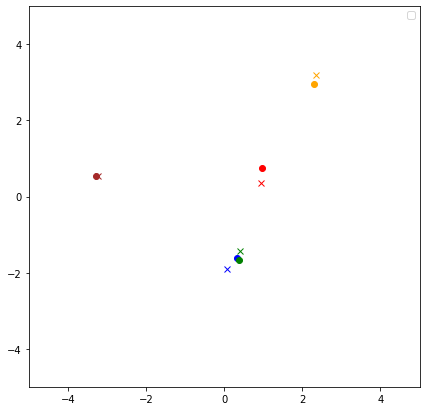

In [105]:
plot_positions(preds[0][0][0], actual[0][0][0])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


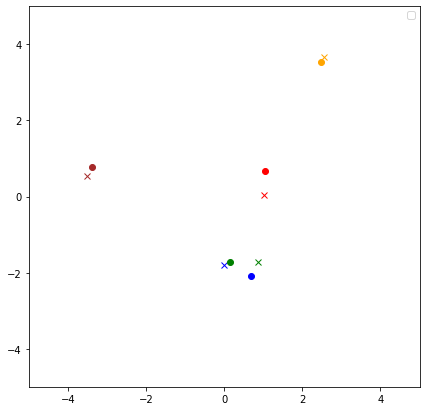

In [106]:
plot_positions(preds[0][0][1], actual[0][0][1])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


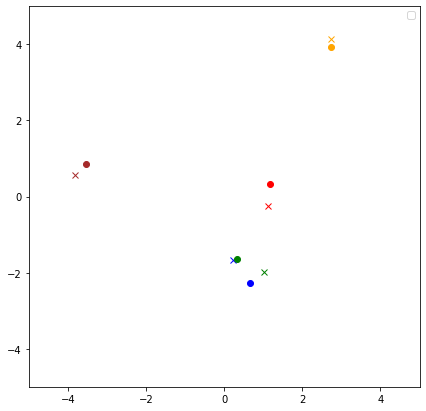

In [107]:
plot_positions(preds[0][0][2], actual[0][0][2])